# FINM 37400
# Homework 3
## Group B4 - Moshe Assaraf, Elie Kostenbaum, Danny Stein, Joseph Padilla

In [37]:
import pandas as pd
import numpy as np
import datetime
import holidays
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy import interpolate


from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

## Functions

In [198]:
def bday(date):
    us_bus = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    return bool(len(pd.bdate_range(date, date,freq=us_bus)))

def prev_bday(date,force_prev=False):
    if isinstance(date,str):
        date = datetime.datetime.strptime(date,'%Y-%m-%d')
        date2str = True
    else:
        date2str = False
        
    if force_prev:
        date += -datetime.timedelta(days=1)
    while not bday(date):
        date += -datetime.timedelta(days=1)
    
    if date2str:
        date = date.strftime('%Y-%m-%d')
        
    return date

def get_coupon_dates(quote_date,maturity_date):

    if isinstance(quote_date,str):
        quote_date = datetime.datetime.strptime(quote_date,'%Y-%m-%d')
        
    if isinstance(maturity_date,str):
        maturity_date = datetime.datetime.strptime(maturity_date,'%Y-%m-%d')
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out


def make_figure_number_issues_paying(CFmatrix):

    mask_issues_paying = (CFmatrix!=0).sum()

    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(mask_issues_paying,marker='*',linestyle='None')

    #set ticks every quarter
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(2,5,8,11)))
    ax.xaxis.set_major_locator(mdates.YearLocator(month=2))

    #format ticks
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=60, horizontalalignment='right')

    ax.margins(x=0)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    plt.ylabel('number of treasury issues with coupon or principal payment')
    plt.title('Number of Treasuries Paying')

    plt.show()



def filter_treasuries(data, t_date=None, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True):
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['CALDT'].values[-1]
    
    outdata = outdata[outdata['CALDT']==t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['TMATDT'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['TMATDT'] < (t_date + np.timedelta64(365*filter_maturity+1,'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['TMATDT'] > (t_date + np.timedelta64(365*filter_maturity_min-1,'D'))
        outdata = outdata[mask_truncate]

    #outdata = outdata[outdata['ITYPE'].isin([11,12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['TDYLD']>0]
        
    return outdata



def calc_cashflows(quote_data, filter_maturity_dates=False):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100


    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF



def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered



def get_maturity_delta(t_maturity,t_current):

    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta



def discount_to_intrate(discount, maturity, n_compound=None):
        
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate




def intrate_to_discount(intrate, maturity, n_compound=None):
    
    if n_compound is None:
        discount = np.exp(-intrate * maturity)
    else:
        discount = 1 / (1+(intrate / n_compound))**(n_compound * maturity)

    return discount    



def compound_rate(intrate,compound_input,compound_output):
    
#    outrate = intrate[['maturity']]
    
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate







def bootstrap(params,maturity):
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate



def nelson_siegel(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3])
    
    return rate





def nelson_siegel_extended(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
    
    return rate




def estimate_curve_ols(CF,prices,interpolate=False):

    if isinstance(prices,pd.DataFrame) or isinstance(prices,pd.Series):
        prices = prices[CF.index].values
    
    mod = LinearRegression(fit_intercept=False).fit(CF.values,prices)

    if interpolate:
        matgrid = get_maturity_delta(CF.columns,CF.columns.min())

        dts_valid = np.logical_and(mod.coef_<1.25, mod.coef_>0)

        xold = matgrid[dts_valid]
        xnew = matgrid
        yold = mod.coef_[dts_valid]

        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')    
        discounts = f(xnew)

    else:
        discounts = mod.coef_    
        
    return discounts




def price_with_rate_model(params,CF,t_current,fun_model, convert_to_discount=True, price_coupons=False):

    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            disc[i] = intrate_to_discount(fun_model(params,mat),mat)
    else:
        disc = fun(params,mat)
        
        
    if price_coupons:
        price = CF * disc
    else:
        price = CF @ disc
    
    return price




def pricing_errors(params,CF,t_current,fun_model,observed_prices):

    price_modeled = price_with_rate_model(params,CF,t_current,fun_model)

    if isinstance(observed_prices,pd.DataFrame) or isinstance(observed_prices,pd.Series):
        observed_prices = observed_prices.values
        
    error = sum((observed_prices - price_modeled)**2)
    
    return error




def estimate_rate_curve(model,CF,t_current,prices,x0=None):

    if model is bootstrap:
        params = estimate_curve_ols(CF,prices,interpolate=False)
        
        CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current=t_current).values
    
        params_optimized = [CF_intervals,params]

    else:
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones((1,4))/10
            elif model is nelson_siegel_extended:
                x0 = np.ones((1,6))
            else:
                x0 = 1        

        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x

    return params_optimized



def process_treasury_quotes(quote_date):
    
    filepath_rawdata = f'../data/treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
    maturity_delta.name = 'maturity delta'

    metrics = rawdata.copy()[['TDATDT','TMATDT','TDPUBOUT','TCOUPRT','TDYLD','TDDURATN']]
    metrics.columns = ['issue date','maturity date','outstanding','coupon rate','yld','duration']
    metrics['yld'] *= 365
    metrics['duration'] /= 365
    metrics['outstanding'] *= 1e6
    metrics['maturity interval'] = get_maturity_delta(metrics['maturity date'], t_current)
    metrics['price'] = rawprices
    
    return metrics


def get_bond(quote_date,maturity=None,coupon=None,selection='nearest'):
    
    metrics = process_treasury_quotes(quote_date)

    if coupon is not None:
        metrics = metrics[metrics['coupon rate']==coupon]
    
    if maturity is not None:
        mats = metrics['maturity interval']

        if type(maturity) is float:
            maturity = [maturity]

        idx = list()

        for m in maturity:

            if selection == 'nearest':
                idx.append(mats.sub(m).abs().idxmin())
            elif selection == 'ceil':
                idx.append(mats.sub(m).where(mats > 0, np.inf).argmin())
            elif selection == 'floor':
                idx.append(mats.sub(m).where(mats < 0, -np.inf).argmax())

        metrics = metrics.loc[idx,:]

    return metrics


def get_bond_raw(quote_date):
    
    filepath_rawdata = f'../data/treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
        
    return rawdata, t_current




def forward_discount(spot_discount,T1,T2):
    return spot_discount.loc[T2] / spot_discount.loc[T1]



def calc_npv(rate=0, cashflows=0, maturities=0, price=0):
        
    temp = cashflows.copy()
    val = sum([cfi/(1+rate)**(maturities[i]) for i, cfi in enumerate(temp)])
    val += - price

    return val


def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

## 1 HBS Case: The Information Content of the Yield Curve

### 1.1 The Term Spread

(1) The term spread is the difference between the long term and short term interest rates (usually the 10-year Treasury rate less the 3-month Treasury rate) and can also been seen as the slope of the US Yield Curve.

(2) The preferred measure of the term spread is the level of the the 10-year Treasury rate less the 3-month Treasury rate as it is what has the predicitive power.

(3) The research work of the Federal Reserve Bank of New York and Arturo Estrella serve as evidence on the term spread's power in prediciting recessions.

(4) All three factors are generally important in analysis of predictive power of the slope of the yield curve, however, the month over month change can be particularly important for smaller magnitudes of level in the term spread. This because at smaller magnitudes of level in term spread a large change would greatly increase the probability of recession. Otherwise, the level of term spread carries the predicitve power, while the level of short rates influence the level of the term spread.

### Term Spread Data

In [20]:
yields_path = r'C:\Users\jnpad\OneDrive\Desktop\University of Chicago\FINM\04. Winter Quarter 2023\FINM 37400 - Fixed Income\Homework\Homework 4\yields_2022-11-30.xlsx'
yields_df = pd.read_excel(yields_path)
yields_df.set_index('caldt', inplace=True)
yields_df.rename(columns={1:'1yr', 2:'2yr', 5:'5yr', 7:'7yr', 10:'10yr', 20:'20yr', 30:'30yr'}, inplace=True)
yields_df


,1yr,2yr,3,5yr,10yr,20yr,30yr
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018
...,...,...,...,...,...,...,...
2022-11-23,4.666103,4.465921,3.886053,3.657613,3.665568,4.010443,3.723134
2022-11-25,4.654875,4.442006,3.859520,3.629335,3.652183,3.995460,3.735102
2022-11-28,4.635645,4.420958,3.868822,3.640823,3.650411,3.996127,3.720517


In [21]:
term_spread = yields_df[['1yr', '10yr']].copy()
term_spread['Term Spread'] = term_spread['10yr']-term_spread['1yr']
term_spread

,1yr,10yr,Term Spread
caldt,,,
1961-06-14,2.935907,3.818819,0.882912
1961-06-15,2.932936,3.862987,0.930051
1961-06-16,2.929949,3.863282,0.933333
1961-06-19,2.920884,3.886205,0.965321
1961-06-20,2.952419,3.886506,0.934087
...,...,...,...
2022-11-23,4.666103,3.665568,-1.000535
2022-11-25,4.654875,3.652183,-1.002692
2022-11-28,4.635645,3.650411,-0.985234


Text(0, 0.5, 'Level (%)')

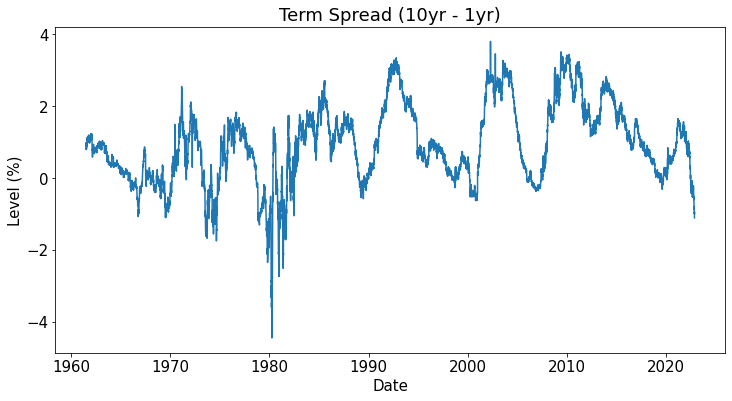

In [31]:
plt.plot(term_spread['Term Spread'])
plt.title('Term Spread (10yr - 1yr)')
plt.xlabel('Date')
plt.ylabel('Level (%)')

Text(0.5, 1.0, 'Term Spread Distribution')

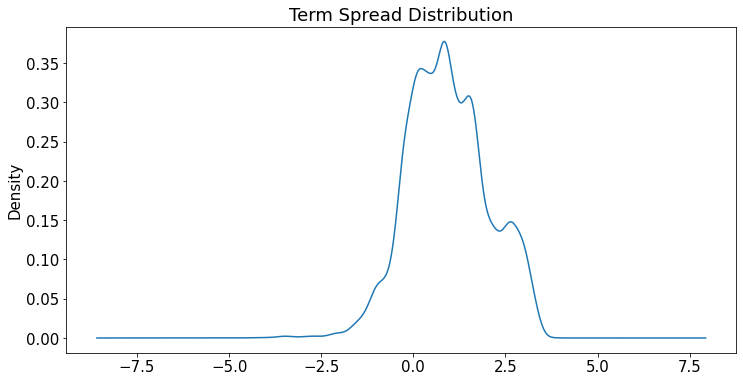

In [32]:
term_spread['Term Spread'].plot.density()
plt.title('Term Spread Distribution')

In [30]:
term_spread['Term Spread'].describe().to_frame()

,Term Spread
count,15346.000000
mean,0.937109
std,1.090494
min,-4.458522
25%,0.155201
50%,0.869642
75%,1.647370
max,3.802430


(5) According to Estrella, when the slope of the yield curve (or, when the level of term spread) is positive, economic growth should be strong over the next four to six quarters. A quick view of the density for the data of the term spread suggests that about 75% percent of observations of the term spread between June 1961 and Novemeber 2022 are greater than ~16bps, or are positive. Therefore, we generally would expect economic growth over most of this timeframe. There are episodes when the term spread enters negative territory, particularly throughout the 1970s and 1980s.

### 1.2 Term Premia

(1) The term premium is an unobservable construct (at worst) or an estimate (at best) proposed by Brian Sack that accounts for the amount of the 10-yr rate not explained by the average of 10 1-yr rates. Sacks found that the 10-yr rate could be expressed as the expected average of the next 10 1-yr rates plus a term premium. It cannot be directly measured because it is unobservable and a conceptual construction used in Sack's findings, although it can be estimated.

(2) Equation 1 states that the 10-yr rate at time t is equal to the expected average of the next 10 1-yr rates plus a term premium (at time t). Equation 2 states that the difference between the 10-yr (time t) rate and 1-yr rate (time t) (the slope of the yield cureve or term spread) is an average of the expected changes in the short rate (future time ts) plus the term premium.

(3) Sacks believes that Estrella focused on just the first term of Equation 2 in the evidence supporting the predictive role of the slope of the yield curve, however, the second term, the term premium, complicated with evidence as it could disrupt the conclusions of Estrella on the slope's predictive power. Sacks argued that flattening of the yield curve did not necessarily suggest slower economic growth. Instead changes in the term premium could offset the flattening effects and have stimulative results for economic growth.

### 1.3

(1) An upward sloping yield curve predicts that the average of expected changes in the future short term rates must be positive. Consequently, we expect the short term rate to increase over time.

(2) Yes, it can be risky to hold long-term bonds should the short-term rates surpass the long-term rates. Investors would be incentivized to move to holding short-term bonds, lowering the prices of the long-term bonds. The risk is compensated by the fact that long-term bonds have higher rates up until the short-term rates surpass them.

(3) With a positive term premium at time t, we cannot conclude that the average of expected changes in the future short term rates must be positive, or that short-term rates will increase over time. The positive term premium could offset a negative average of expected changes in the future short term rates or it could augment to already postive average of expected changes. Therefore, we can't be certain of our conlusion about the movement of short-term rates in the future.

### 2 Calculating Forwards

The data below was altered for ease of calculation. For simplicity, we reset issue dates and maturity for the March issuances as 03-30, given that the class code for the cashflow matrix would output an extra coupon date (i.e., the code would take 03-30 as a coupon date and then mature a bond on the following day 03-31). This created jumps in the cash flow matrix and consequently in the discount curve. As a result, we assumed, more realistically, that final coupon dates occur on the maturity date and for ease adjusted them to a 03-30 issue and maturity dates.

In [199]:
treasuries_path = r'C:\Users\jnpad\OneDrive\Desktop\University of Chicago\FINM\04. Winter Quarter 2023\FINM 37400 - Fixed Income\Homework\Homework 4\selected_treasury_rates.xlsx'

treasuries = pd.read_excel(treasuries_path)
treasuries.set_index('KYTREASNO', inplace=True)
treasuries['CALDT'] = "2022-03-31"
treasuries.rename(columns = {'maturity date':'TMATDT', 'coupon rate': 'TCOUPRT', 'ytm':'TDYLD'}, inplace=True)
treasuries

,issue date,TMATDT,maturity,TCOUPRT,price,TDYLD,CALDT
KYTREASNO,,,,,,,
206896,2015-09-30,2022-09-30,0.501027,1.750,100.363281,0.010144,2022-03-31
207688,2021-03-30,2023-03-30,0.999316,0.125,98.457031,0.016804,2022-03-31
207775,2021-09-30,2023-09-30,1.500342,0.250,97.218750,0.021307,2022-03-31
207077,2017-03-30,2024-03-30,2.001369,2.125,99.570312,0.023294,2022-03-31
207416,2019-09-30,2024-09-30,2.502396,1.500,97.621094,0.024680,2022-03-31
207507,2020-03-30,2025-03-30,3.000684,0.500,94.175781,0.025101,2022-03-31
207256,2018-09-30,2025-09-30,3.501711,3.000,101.554688,0.025142,2022-03-31
207337,2019-03-30,2026-03-30,4.000000,2.250,98.929688,0.025154,2022-03-31
207777,2021-09-30,2026-09-30,4.501027,0.875,93.042969,0.025020,2022-03-31


In [200]:
MODEL = bootstrap

CF = calc_cashflows(treasuries)
CF

,2022-09-30,2023-03-30,2023-09-30,2024-03-30,2024-09-30,2025-03-30,2025-09-30,2026-03-30,2026-09-30,2027-03-30,2027-09-30,2028-03-30,2028-09-30,2029-03-30
KYTREASNO,,,,,,,,,,,,,,
206896,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207688,0.0625,100.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207775,0.1250,0.1250,100.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207077,1.0625,1.0625,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207416,0.7500,0.7500,0.7500,0.7500,100.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207507,0.2500,0.2500,0.2500,0.2500,0.2500,100.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207256,1.5000,1.5000,1.5000,1.5000,1.5000,1.5000,101.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207337,1.1250,1.1250,1.1250,1.1250,1.1250,1.1250,1.1250,101.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207777,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,100.4375,0.0000,0.0000,0.0000,0.0000,0.0000


In [201]:
prices = treasuries['price'][CF.index]

params_boot = estimate_rate_curve(MODEL,CF, t_current,prices)

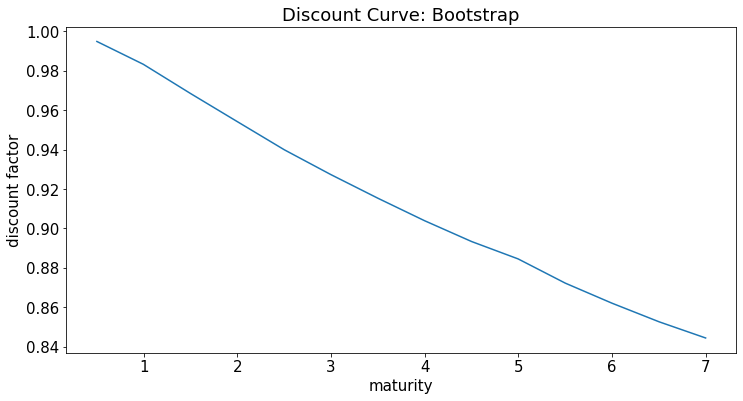

In [202]:
plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

In [203]:
inc = .5
max_maturity = treasuries['maturity'].max()
maturity_grid = np.arange(inc,max_maturity+.5,inc)

spot = bootstrap(params_boot, maturity_grid)

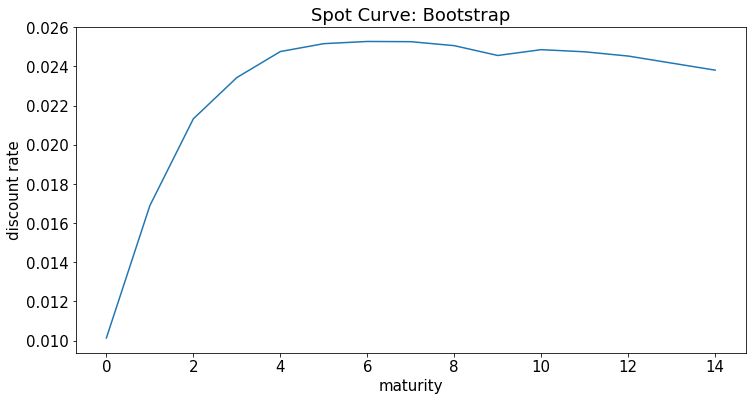

In [204]:
plt.plot(spot)
plt.xlabel('maturity')
plt.ylabel('discount rate')
plt.title('Spot Curve: Bootstrap')
plt.show()

### 2.2 Forward Discount Curve

In [215]:
## The below was adjusted from treasury_cmds for the purposes of this homework

def extract_spot_curves(data, model, delta_maturity = .5, T=6.5,calc_forward=False, delta_forward_multiple = 1, filter_maturity_dates=False, filter_tips=True):

    CF = calc_cashflows(data) #filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=filter_maturity_dates)
    prices = data['price'][CF.index] #rawprices[CF.index]

    ###
    params = estimate_rate_curve(model,CF,t_current,prices)
    
    if model == nelson_siegel_extended:
        params0 = estimate_rate_curve(nelson_siegel,CF,t_current,prices)
        x0 = np.concatenate((params0,(1,1)))
        params = estimate_rate_curve(model,CF,t_current,prices,x0=x0)
        
    else:
        params = estimate_rate_curve(model,CF,t_current,prices)

    ###
    maturity_grid = np.arange(0,T+delta_maturity,delta_maturity)
    maturity_grid[0] = .01
    
    curves = pd.DataFrame(index = pd.Index(maturity_grid,name='maturity'))
    # adjust earliest maturity from 0 to epsion
    curves.columns.name = quote_date
    
    curves['spot rate']= model(params,maturity_grid)

    curves['spot discount'] = intrate_to_discount(curves['spot rate'].values,curves.index.values)
    
    
    
    if calc_forward:
        delta_forward = delta_forward_multiple * delta_maturity
        
        curves['forward discount'] = curves['spot discount'] / curves['spot discount'].shift(delta_forward_multiple)

        # first value of forward is spot rate
        maturity_init = curves.index[0:delta_forward_multiple]
        curves.loc[maturity_init,'forward discount'] = curves.loc[maturity_init,'spot discount']
        
        curves.insert(2,'forward rate', -np.log(curves['forward discount'])/delta_forward)
        
    return curves

In [216]:
curves = extract_spot_curves(treasuries, model=MODEL, calc_forward=True)
curves

2022-03-31 00:00:00,spot rate,spot discount,forward rate,forward discount
maturity,,,,
0.01,0.003498,0.999965,0.000070,0.999965
0.50,0.010137,0.994944,0.010067,0.994979
1.00,0.016895,0.983247,0.023653,0.988243
1.50,0.021327,0.968516,0.030192,0.985017
2.00,0.023432,0.954217,0.029746,0.985237
2.50,0.024761,0.939975,0.030077,0.985074
3.00,0.025164,0.927288,0.027178,0.986503
3.50,0.025276,0.915334,0.025949,0.987109
4.00,0.025265,0.903879,0.025188,0.987485


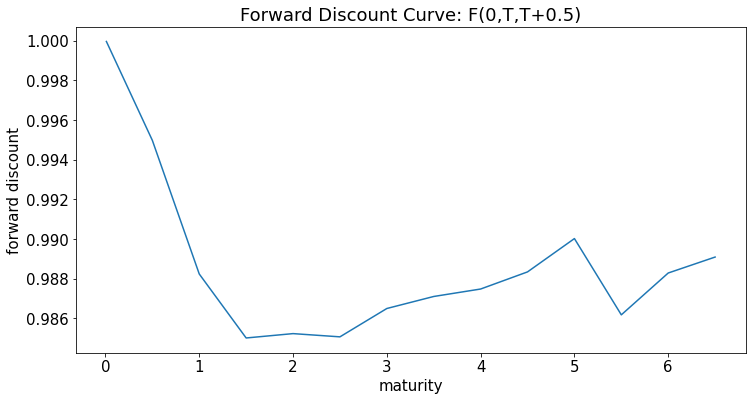

In [218]:
plt.plot(curves['forward discount'])
plt.xlabel('maturity')
plt.ylabel('forward discount')
plt.title('Forward Discount Curve: F(0,T,T+0.5)')
plt.show()

### 2.3 Forward Rates

First the forward discount factor is calculated $F(t,T_1, T_2)$ with the discount factors. Then, we log transform and divide by the difference in maturity to get the forward rate $f(t,T_1, T_2)$.

In [242]:
forward_rates = pd.DataFrame(index=['Forward Rate $f(t,T_1, T_2)$'])
forward_rates['$f(t,2,2.5)$'] = -np.log(curves['spot discount'].iloc[5]/curves['spot discount'].iloc[4])/0.5
forward_rates['$f(t,5,5.5)$'] = -np.log(curves['spot discount'].iloc[11]/curves['spot discount'].iloc[10])/0.5
forward_rates

,"$f(t,2,2.5)$","$f(t,5,5.5)$"
"Forward Rate $f(t,T_1, T_2)$",0.030077,0.027826


Since we also already have the forward discount rate in the previous table of curves, we can also yield the same calculations using those values.

In [245]:
forward_rates2 = pd.DataFrame(index=['Forward Rate $f(t,T_1, T_2)$'])
forward_rates2['$f(t,2,2.5)$'] = -np.log(curves['forward discount'].iloc[5])/0.5
forward_rates2['$f(t,5,5.5)$'] = -np.log(curves['forward discount'].iloc[11])/0.5
forward_rates2

,"$f(t,2,2.5)$","$f(t,5,5.5)$"
"Forward Rate $f(t,T_1, T_2)$",0.030077,0.027826


### 2.4

In an FRA, the party entering the agreement pays the spot rate $r(T_1,T_2)$ on the notional amount. This spot rate is calculated from the forward discount curve. The investor then receives the forward rate less the spot rate multplied by the notional and maturity time difference. The forward discount rate calculated above is used to calculated the forward rate in the agreement.